# **ODRA Quantum Computing Workshop - 17.09.2025**
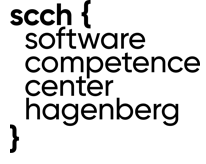

# Grover's algorithm

This tutorial is based on IBMs Qiskit Textbook, for more informatin see reference [[1]](#further-reading).

## Search in unstructured data

We want to find an element $\omega$ in an unstructed list of $N$ items. If we have no further information, in the worst case a classical algorithm has to check every element, this means $N$ operations need to be performed.

Grover's algorithm is a quantum routine that allows us to perfrom this search with $\sqrt{N}$ steps, which results in a quadratic speedup.

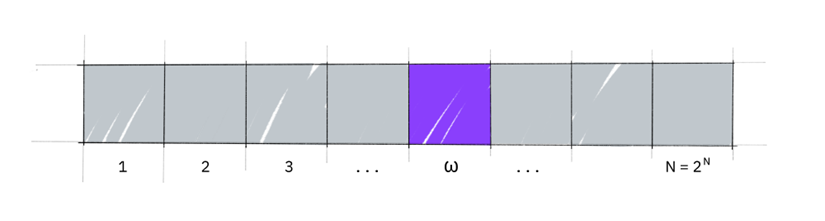


Grover's algorithm works in three steps:
1. initialize $n = \log{N}$ qubits in an equal superposition state (e.g. for $N=8=2^3$ we need 3 qubits)
1. flip the sign of the target state $\ket{\omega}$
1. amplify the amplitude of the target state: invert all amplitudes about the mean

Steps 2 and 3 together are called amplitude amplification. We can repeat amplitude amplification several times to put even more weight on the desired state.

After several applications of amplitude amplification we measure the $n$-qubit state and will find the state $\ket{\omega}$ with very large probability.

In fact there is an expression how often one should repeat amplitude amplification to get the maximum possible weight on the state. This is given by $$r \approx \frac{\pi}{4}\sqrt{N}$$

Thus we obtain our result after just $\sqrt{N}$ steps, in contrast to the classically required $N$ steps.

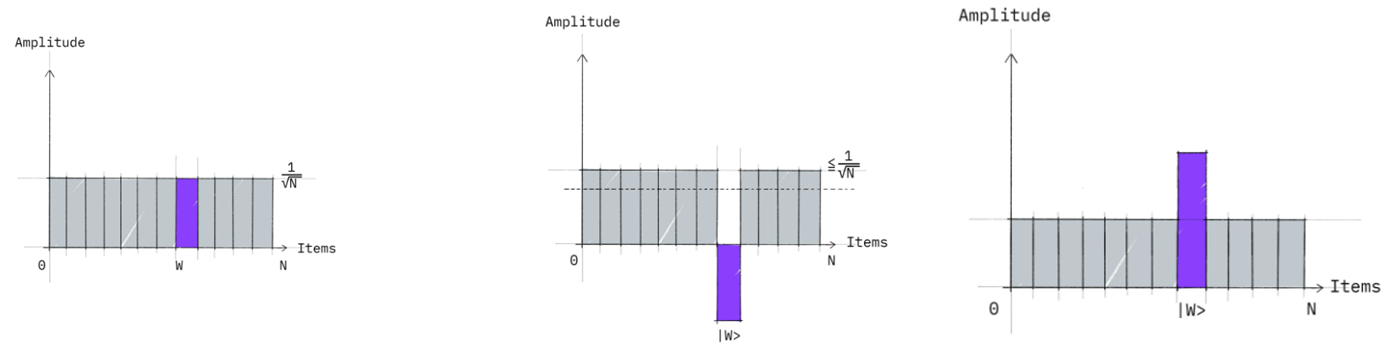

## Let's code

Since Grover's algorithm can be divided in these three steps, we will also structure our program into these three building blocks.

In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

import numpy as np

import matplotlib.pyplot as plt

### The initial state for Grover's algorithm - an equal superposition of all basis states

As we have already seen, the state before the amplitude amplification is the equal equal superposition state of all our qubits. 

For the beginning we will work with a database holding just $N=8$ values. This means we need 3 qubits (so we can represent $8=2^3$ states).

We already know how we put a qubit in superpostition: with the Hadamard gate. So the first step in our circuit will be to apply this gate to all qubits.

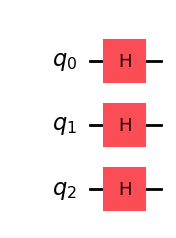

In [4]:
n_qubits = 3
circuit = QuantumCircuit(n_qubits)

circuit.h(range(n_qubits)) # bring the qubits in equal superposition

circuit.draw(output='mpl')

### Next we create the sign flip circuit

This part of the circuit is also called the oracle.

For our example we will use a database with 8 entries, which we can represent with 3 qubits ($2^3=8$).



To flip the sign of a single state, e.g. state $\ket{110}$, we need a quantum gate $U_\text{flip}$ with the matrix representation

$$
U_\text{flip} = \begin{bmatrix} 
    1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & \textcolor{red}{-1} & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

In Qiskit it is also possible to create custom gates from the basic building blocks. We will make use of this feature to create a new sign-flip gate.

In [5]:
# the circuit for flipping the sign of the |110> state
def sign_flip_circ():
    qc = QuantumCircuit(3)
    qc.x(0)
    qc.ccz(0, 1, 2)
    qc.x(0)
    return qc

# convert the sign_flip circuit into a reusable quantum gate
def sign_flip():
    qc = sign_flip_circ()
    U_flip = qc.to_gate()
    U_flip.name = "$U_\\text{flip}$"
    return U_flip

The sign_flip circuit can also be visualized:

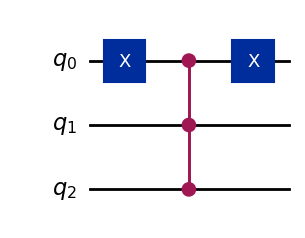

In [6]:
sign_flip_circ().draw(output='mpl')

And if we use the custom gate $U_\text{flip}$ as a building block in another circuit it will looks like this:

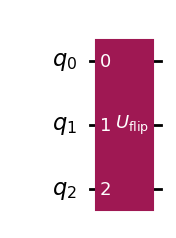

In [8]:
qc = QuantumCircuit(3)
qc.append(sign_flip(), [0, 1 ,2])
qc.draw(output='mpl')

### The circuit for reflection

The circuit for reflecting the amplitudes on the mean value (also called diffuser) can be created in a general way for an n-qubit system.

We will also create a custom gate for this:

In [9]:
def diffuser_circ(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # add a global phase of -1
    qc.x(range(nqubits))
    qc.u(np.pi, np.pi, np.pi + np.pi, range(nqubits))
    return qc

def diffuser(nqubits):
    qc = diffuser_circ(nqubits)
    U_s = qc.to_gate()
    U_s.name = "$U_\\text{reflect}$"
    return U_s

We visualize the diffuser for 3 qubits:

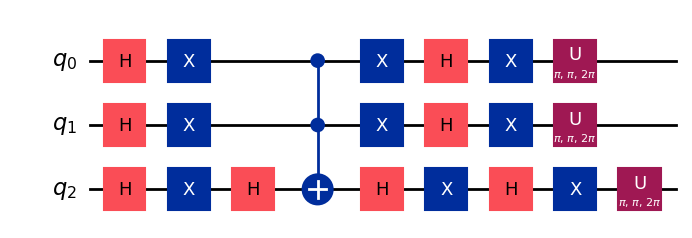

In [10]:
diffuser_circ(3).draw(output='mpl')

## Assemble a circuit for Grover's algorithm with our custom building blocks

As stated in the beginning we will now build a circuit where we perform amplitude amplification two times ($\frac{\pi}{4}\sqrt{N} \approx 2$). The circuit is composed of the following steps:
1. init all qubits to $\ket{0}$
1. bring them in an equal superposition of all possible states (in our case these are the 8 basis states)
1. first Grover iteration
    - flip the sign of the marked state
    - perform the reflection about the mean
1. second Grover iteration
    - flip the sign of the marked state
    - perform the reflection about the mean
1. measure the output

When running our circuit we also want to inspect the statevector of the system after each step. For this we create a list of names and call the `save_statevector` method of qiskit at specified points.

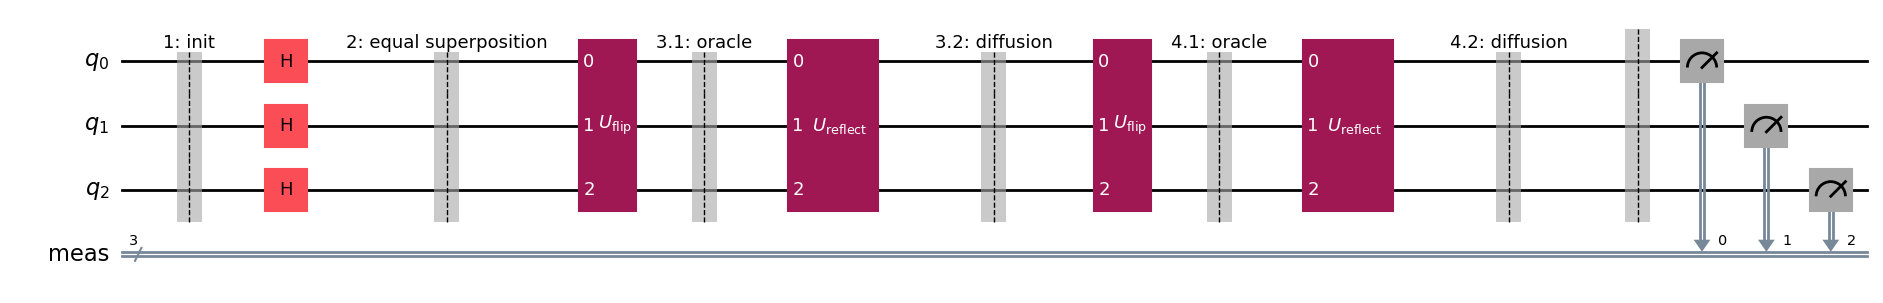

In [11]:
step_lbls = ['1: init', '2: equal superposition', '3.1: oracle', '3.2: diffusion', '4.1: oracle', '4.2: diffusion']

n_qubits = 3
# 1. initialize a 3 qubit circuit
circuit = QuantumCircuit(n_qubits)
circuit.save_statevector(label=step_lbls[0])

# 2. bring the qubits in equal superposition
circuit.h(range(n_qubits))
circuit.save_statevector(label=step_lbls[1])

# 3.1. first application of the sign_flip gate
circuit.append(sign_flip(), [0, 1, 2])
circuit.save_statevector(label=step_lbls[2])

# 3.2 first application of the reflection gate
circuit.append(diffuser(n_qubits), [0, 1 ,2])
circuit.save_statevector(label=step_lbls[3])

# 4.1 second application of the sign_flip gate
circuit.append(sign_flip(), [0, 1, 2])
circuit.save_statevector(label=step_lbls[4])

# 4.2 second application of the reflection gate
circuit.append(diffuser(n_qubits), [0, 1 ,2])
circuit.save_statevector(label=step_lbls[5])

# 5. perform the measurement
circuit.measure_all()

circuit.draw(output='mpl', fold=-1)

If we want to see the full circuit with our custom gates expanded we can use the `decompose()` method on the circuit.

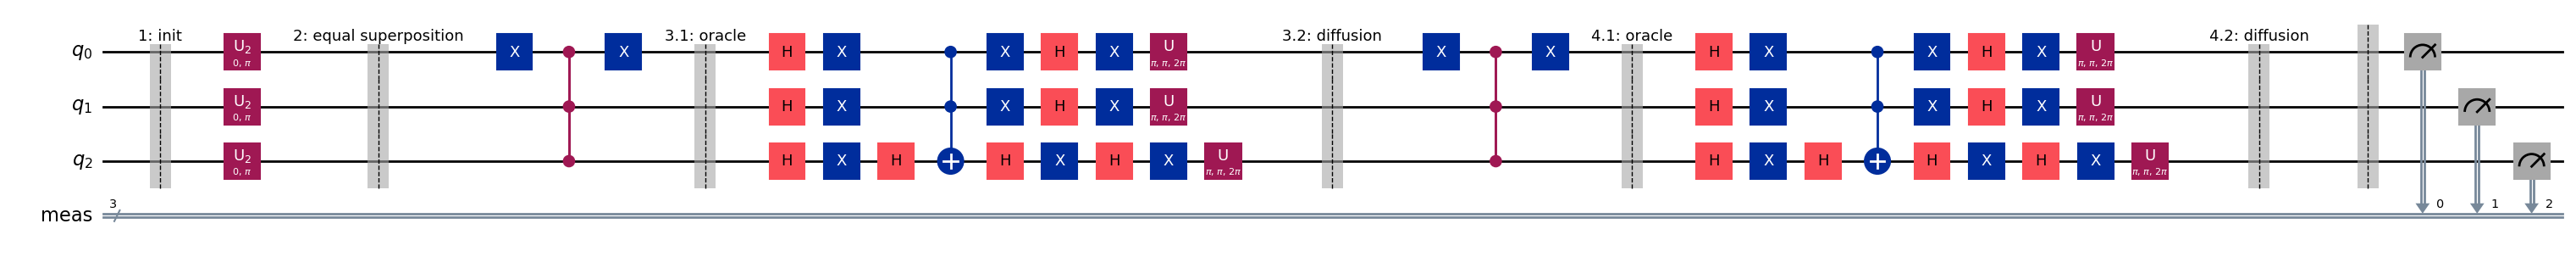

In [12]:
circuit.decompose().draw(output='mpl', fold=-1)

### That's it - let's simulate the circuit

This is still a small quantum circuit that can be simulated on our personal hardware. So we use the `AerSimulator`.

Note: Because we have custom-built gates we need to apply `decompose()` to the circuit before the simulation. This basically expands the custom gates into the primitive gates known by the simulator.

We expect to see the highest number of counts on the element "110", the element we have marked with our `sign_flip` circuit.

Counts(ideal): {'100': 66, '010': 90, '000': 84, '001': 96, '101': 77, '111': 67, '011': 84, '110': 9436}


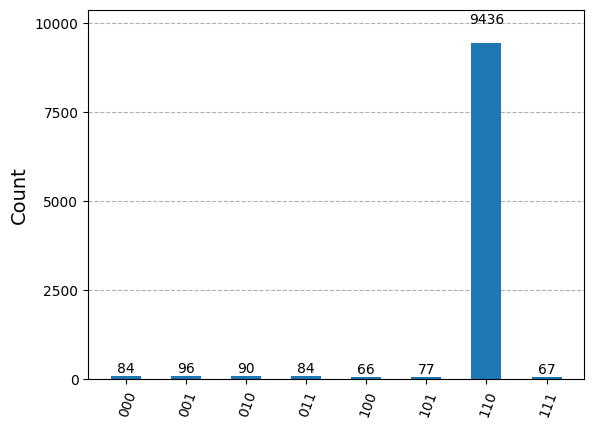

In [13]:
sim = AerSimulator()

num_shots = 10000
result = sim.run(circuit.decompose(reps=2), shots=num_shots).result()
counts = result.get_counts(0)
print('Counts(ideal):', counts)
plot_histogram(counts)

## Step by step inspection of the quantum statevector

Remember that in general the amplitudes in a quantum state are complex numbers. In our circuit the amplitues take only real numbers between -1 and 1. Therefore we can nicely plot the amplitudes of each step.

In [14]:
# plot routine to visualize the real part of a statevector obtained during quantum circuit smulation
def plotStateVectorRealPart(data, n: int, svName: str=None, title=None, ylim=[-1.1, 1.1]):
    if svName is not None:
        title = f"\"{svName}\""
    elif title is None:
        title = "probability amplitudes for basis states"
    if svName is not None:
        sv = data.data(0)[svName]
    else:
        sv = data
    lbls = [np.binary_repr(i, width=n) for i in range(2**n)]

    fig, ax = plt.subplots(figsize=(5,3))
    ax.grid(axis='y')
    ax.bar(lbls, np.real(sv))
    if "oracle" in svName:
        plt.axhline(y=np.mean(np.real(sv)), color='r', linestyle='--')
    ax.set_ylim(ylim)
    ax.set_ylabel("amplitude")
    ax.set_title(title)
    plt.show()

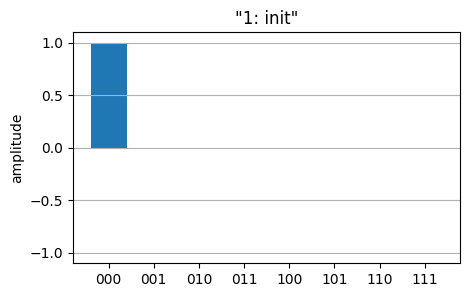

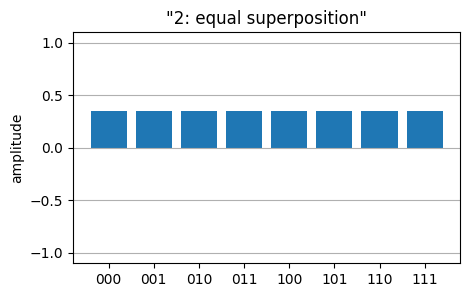

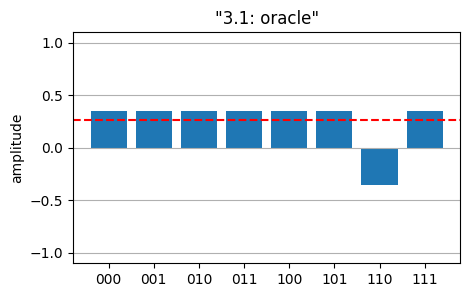

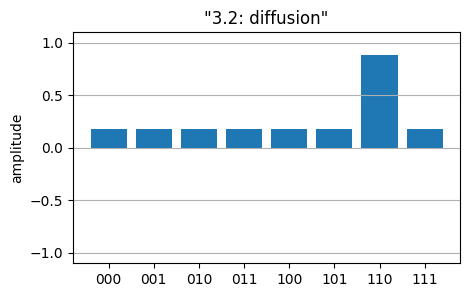

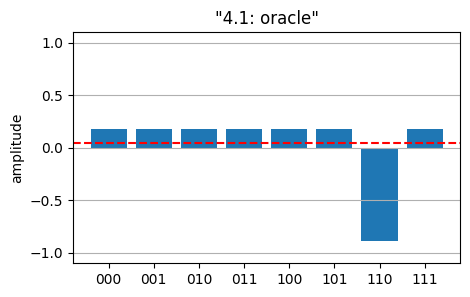

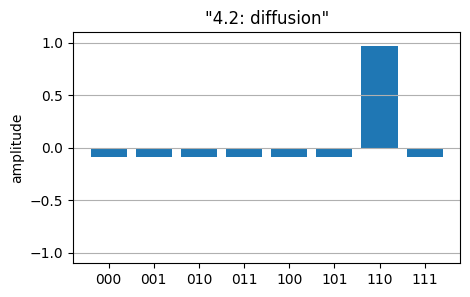

In [13]:
plots_sv = []
for lbl in step_lbls:
    plots_sv.append(plotStateVectorRealPart(result, n_qubits, lbl))

### Run Grover's algorithm on real quantum hardware

When submitting this algorithm to real quantum hardware, we have to modify the circuit a little bit (e.g. remove statevector snapshots). So let's build it again:

In [14]:
runQuantumHW = False # flag for deactivating the execution of this section
jobIdentifier = 'cqwr7neae5gg008mggbg' # fetch data for already executed job
#jobIdentifier = None
if runQuantumHW:
    n_qubits = 3
    qmCirc = QuantumCircuit(n_qubits)
    qmCirc.h(range(n_qubits))
    qmCirc.append(sign_flip(), [0, 1, 2])
    qmCirc.append(diffuser(n_qubits), [0, 1 ,2])
    qmCirc.append(sign_flip(), [0, 1, 2])
    qmCirc.append(diffuser(n_qubits), [0, 1 ,2])
    qmCirc.measure_all()

In [15]:
if runQuantumHW or jobIdentifier is not None:
    from qiskit_ibm_runtime import QiskitRuntimeService
    service = QiskitRuntimeService()
if runQuantumHW:    
    backend_quantum = service.least_busy(simulator=False, operational=True)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-16 16:23:25,587: Default instance not set. Searching all available instances.


In [16]:
if runQuantumHW:
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

    pm = generate_preset_pass_manager(backend=backend_quantum, optimization_level=1)
    isa_circuit = pm.run(qmCirc.decompose(reps=2))
    #isa_circuit.draw()

In [17]:
if runQuantumHW:
    from qiskit_ibm_runtime import SamplerV2 as Sampler

    sampler = Sampler(backend_quantum)
    job = sampler.run([(isa_circuit,)], shots=1000)

In [18]:
if jobIdentifier is not None:
    job = service.job(jobIdentifier)
job_result = job.result()
counts_quantum = job_result[0].data.meas.get_counts()
print('Counts(ibm):', counts_quantum)
plot_histogram(counts_quantum)

RuntimeJobNotFound: 'Job not found: cqwr7neae5gg008mggbg'

# Your Task: Solving a simple Sudoku

Our problem is a 2×2 binary sudoku, which in our case has two simple rules:
- No column may contain the same value twice
- No row may contain the same value twice

This Sudoku is visualized below, where the variables $v_0, v_1, v_2$ and $v_3$ can take the values 0 or 1.

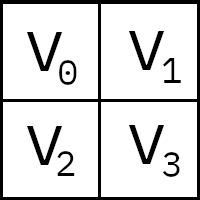

We can easily solve this on our own, and see that there are two possible solutions:
$$\begin{pmatrix}1 & 0 \\ 0 & 1 \end{pmatrix} \qquad \text{and} \qquad \begin{pmatrix}0 & 1 \\ 1 & 0 \end{pmatrix}$$

Here we want to show how Grover's algorithm can be used for such type of problems. So we formulate the Sudoko game as a quantum algorithm.

To apply to the rules of the Sudoku game, the variables are constrained:
$$\begin{align*}
v_0 \neq v_1 & \qquad \text{top row} \\
v_2 \neq v_3 & \qquad \text{bottom row} \\
v_0 \neq v_2 & \qquad \text{left column} \\
v_1 \neq v_3 & \qquad \text{right column}
\end{align*}$$

In [ ]:
def sudoku_oracle(qc: QuantumCircuit, clause_list, clause_qubits):
    ...

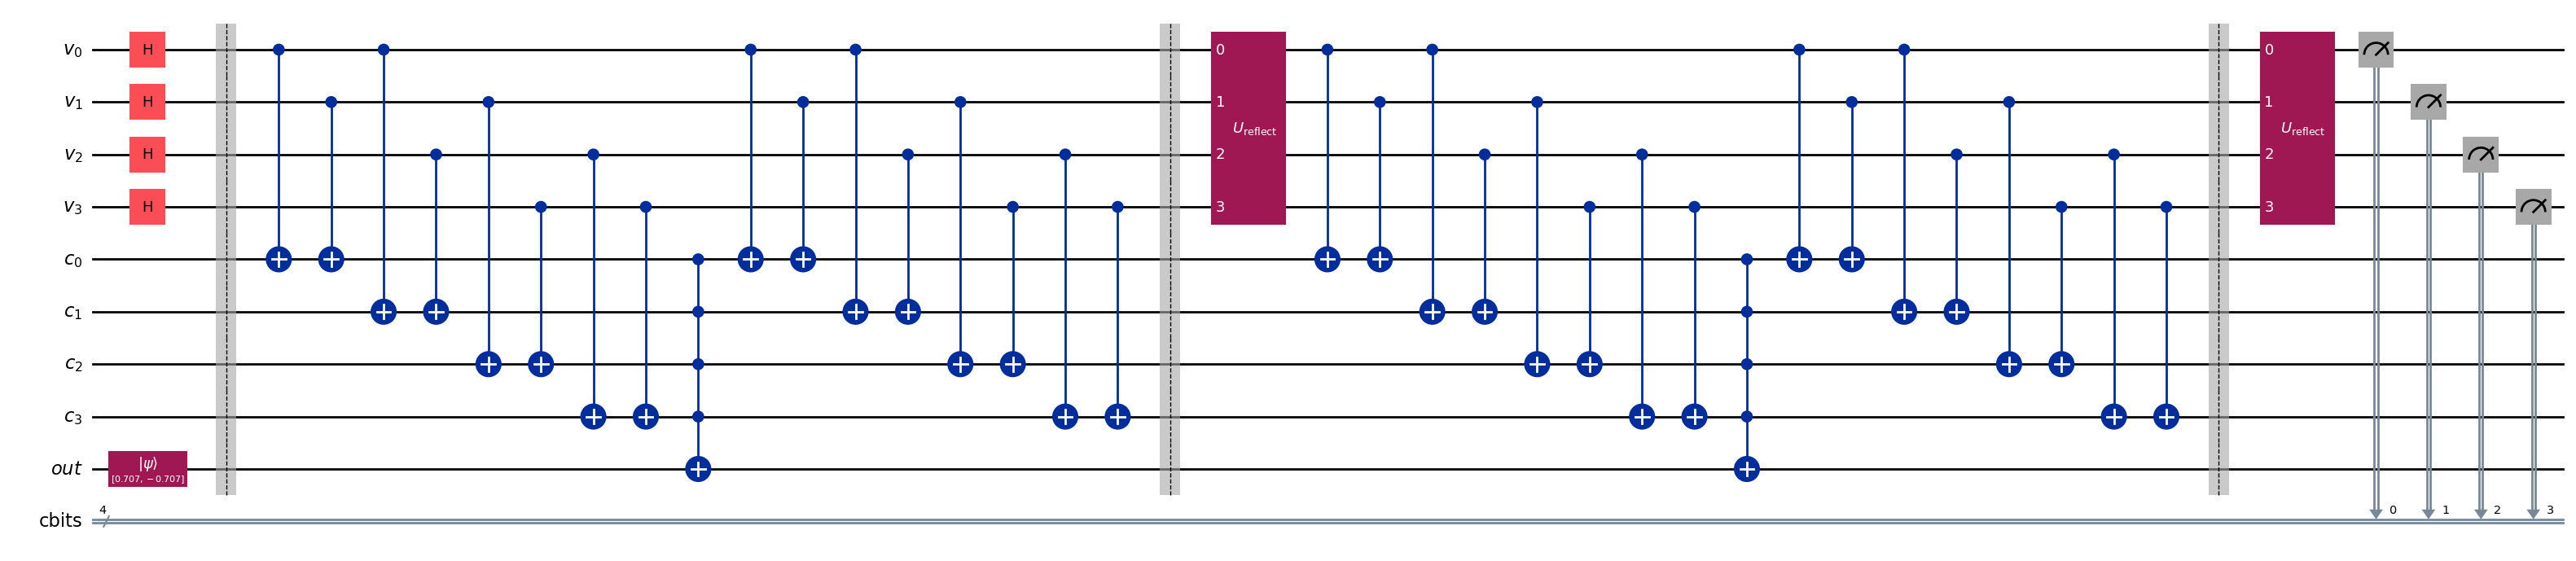

In [26]:
from qiskit import ClassicalRegister, QuantumRegister
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(output='mpl', fold=-1)

Counts(ideal): {'1100': 38, '1000': 41, '0110': 4736, '1101': 60, '1010': 38, '1110': 31, '1001': 4693, '0101': 42, '1111': 46, '0001': 37, '0100': 51, '0000': 38, '0010': 36, '1011': 39, '0111': 33, '0011': 41}


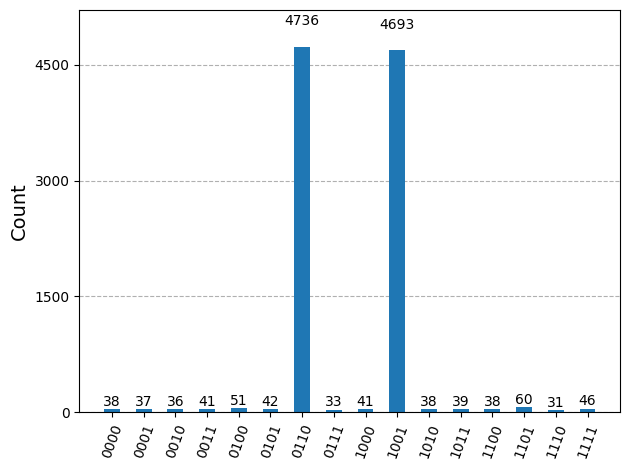

In [27]:
sim = AerSimulator()

num_shots = 10000
result = sim.run(qc.decompose(reps=4), shots=num_shots).result()
counts = result.get_counts(0)
print('Counts(ideal):', counts)
plot_histogram(counts)

# High-Level Version of Grover's algorithm

So far, we have seen how to build quantum algorithms from sratch by assembling quantum gates to form a quantum circuit that can be simulated or directly executed on quantum hardware. 

Many frameworks already provide a more abstract access to quantum algorithms. For example we can also use a built-in function in the Pennylane framework (https://pennylane.ai/) to run Grover's algorithm. See also reference [[2]](#further-reading).

required Python packages:

`pip install pennylane`

In [2]:
!pip install pennylane
import pennylane as qml

To show this functionality, we provide an example: searching for two items in a database with $64=2^6$ entries.

First specify the number of qubits as well as the pattern (or multiple patterns) we are looking for:

In [6]:
n_qubits = 6

patterns = np.array([
    [0, 1, 0, 1, 1, 0], 
    [1, 1, 1, 0, 0, 0]
    ])

How often the amplitude amplification should be performed can be estimated if we know (IRL: guess) the number of occurences of the patterns $M$ we want to match, as well as the number of items in our database $N$

$$\text{number of iterations} \approx \left \lceil \frac{\pi}{4} \sqrt{\frac{N}{M}} \right \rceil$$

In [7]:
# calculate the optimal numbers of Grover iterations
M = len(patterns)
N = 2**n_qubits
iterations = int(np.round(np.sqrt(N / M) * np.pi / 4))
print(f"optimal number of iterations: {iterations}")

optimal number of iterations: 4


Now we use the Pennylane framework to create the Grover search circuit. This follows the same steps as before, but now with built-in high-level functionality.

In particular we use the following steps:
1. apply the `Hadamard` gate for creating the initial equal superposition state (this is very similar to the Qiskit framework).
1. Iterations for amplitude amplification:
    - use the `FlipSign` method as our oracle function
    - apply the `GroverOperator` 
1. measure the output with `probs` (get the probabilities for each state)
    
This functionality is fully provided by Pennylane. That makes it really easy to implement the quantum algorithm.

Remark: When dealing with more applied problems, the hard work is in the design of the oracle function and its implementation as a quantum circuit.

In [8]:
# setup of quantum computing device
wires = list(range(n_qubits))
dev = qml.device("default.qubit", wires=n_qubits, shots=10000)

# the "Pennylane way" of creating circuits
@qml.qnode(dev)
def grover_circuit():
    # Initial state preparation
    for wire in wires:
        qml.Hadamard(wires=wire)

    # Grover's iterator
    for _ in range(iterations):
        for p in patterns:
            qml.FlipSign(p, wires=wires)
        qml.templates.GroverOperator(wires)

    return qml.probs(wires=wires)

That's it. We can now execute our circuit:

In [9]:
results = grover_circuit()
results

array([0.000e+00, 0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04, 0.000e+00,
       0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00, 4.951e-01, 0.000e+00,
       1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04,
       0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 5.040e-01, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

And visualize the results:

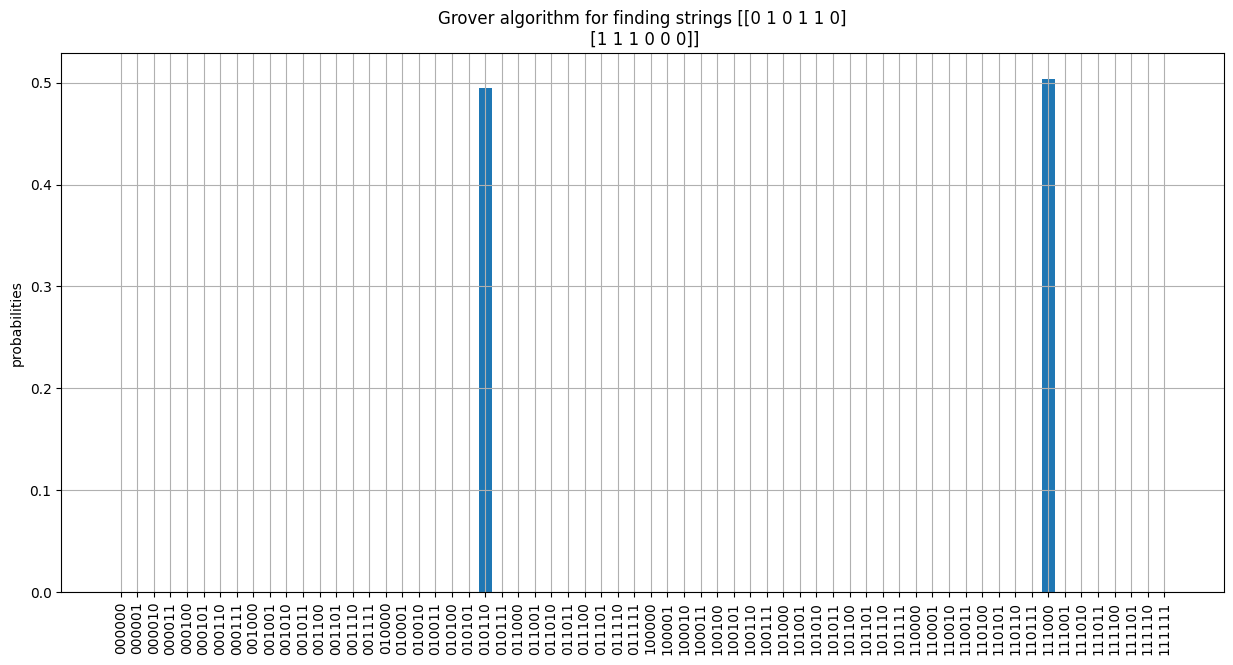

In [10]:
lbls = [np.binary_repr(i, width=n_qubits) for i in range(2**n_qubits)]
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(lbls, results)
ax.grid(True)
ax.set_ylabel("probabilities")
ax.set_title(f"Grover algorithm for finding strings {patterns}")
plt.xticks(rotation="vertical")
plt.show()

## Further Reading

The examples in this Notebook are based on the following material:

[1] https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb

[2] https://pennylane.ai/qml/demos/tutorial_grovers_algorithm/